# Define Utility Functions

In [1]:
#@title
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models import parse_gan_type
from utils import to_tensor
from utils import postprocess
from utils import load_generator
from utils import factorize_weight

%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

def sample(generator, gan_type, num=1, seed=0):
  """Samples latent codes."""
  torch.manual_seed(seed)
  codes = torch.randn(num, generator.z_space_dim).cuda()
  if gan_type == 'pggan':
    codes = generator.layer0.pixel_norm(codes)
  elif gan_type == 'stylegan':
    codes = generator.mapping(codes)['w']
    codes = generator.truncation(codes, trunc_psi=0.7, trunc_layers=8)
  elif gan_type == 'stylegan2':
    codes = generator.mapping(codes)['w']
    codes = generator.truncation(codes, trunc_psi=0.5, trunc_layers=18)
  codes = codes.detach().cpu().numpy()
  return codes


def synthesize(generator, gan_type, codes):
  """Synthesizes images with the give codes."""
  if gan_type == 'pggan':
    images = generator(to_tensor(codes))['image']
  elif gan_type in ['stylegan', 'stylegan2']:
    images = generator.synthesis(to_tensor(codes))['image']
  images = postprocess(images)
  return images


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

# Select a Model

In [2]:
#@title { display-mode: "form", run: "auto" }
model_name = "stylegan_animeface512" #@param ['stylegan_animeface512', 'stylegan_car512', 'stylegan_cat256', 'pggan_celebahq1024', 'stylegan_bedroom256']

generator = load_generator(model_name)
gan_type = parse_gan_type(generator)

Building generator for model `stylegan_animeface512` ...
Finish building generator.
Loading checkpoint from `checkpoints/stylegan_animeface512.pth` ...
Finish loading checkpoint.


# Sample Latent Codes

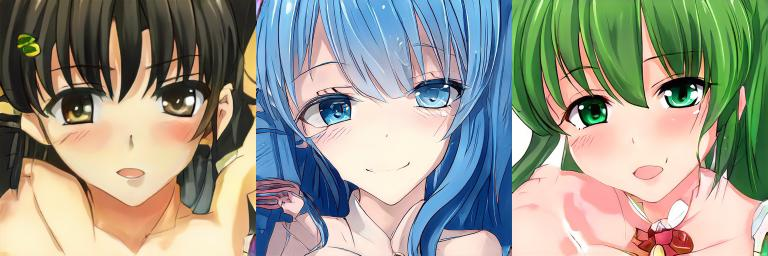

In [3]:
#@title { display-mode: "form", run: "auto" }

num_samples = 3 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 2 #@param {type:"slider", min:0, max:1000, step:1}

codes = sample(generator, gan_type, num_samples, noise_seed)
images = synthesize(generator, gan_type, codes)
imshow(images, col=num_samples)

# Factorize & Edit

torch.Size([3, 3, 512, 512]) torch.Size([512, 1024]) (3, 3, 512, 512)
torch.Size([3, 3, 512, 512]) torch.Size([512, 1024]) (3, 3, 512, 512)
torch.Size([3, 3, 512, 512]) torch.Size([512, 1024]) (3, 3, 512, 512)
torch.Size([3, 3, 512, 512]) torch.Size([512, 1024]) (3, 3, 512, 512)
torch.Size([3, 3, 512, 512]) torch.Size([512, 1024]) (3, 3, 512, 512)
torch.Size([3, 3, 512, 512]) torch.Size([512, 1024]) (3, 3, 512, 512)
torch.Size([3, 3, 512, 512]) torch.Size([512, 1024]) (3, 3, 512, 512)
torch.Size([3, 3, 512, 256]) torch.Size([512, 512]) (3, 3, 512, 256)
torch.Size([3, 3, 256, 256]) torch.Size([512, 512]) (3, 3, 256, 256)
torch.Size([3, 3, 256, 128]) torch.Size([512, 256]) (3, 3, 256, 128)
torch.Size([3, 3, 128, 128]) torch.Size([512, 256]) (3, 3, 128, 128)
torch.Size([3, 3, 128, 64]) torch.Size([512, 128]) (3, 3, 128, 64)
torch.Size([3, 3, 64, 64]) torch.Size([512, 128]) (3, 3, 64, 64)
torch.Size([3, 3, 64, 32]) torch.Size([512, 64]) (3, 3, 64, 32)
torch.Size([3, 3, 32, 32]) torch.Size(

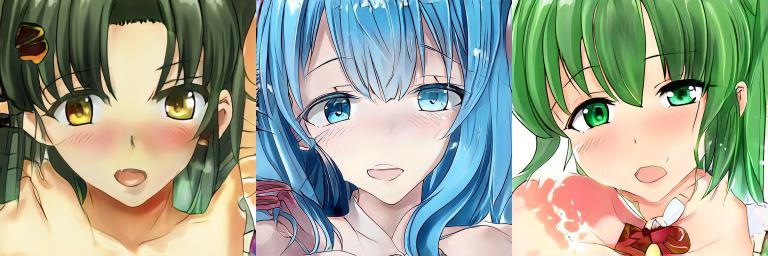

In [7]:
#@title { display-mode: "form", run: "auto" }

layer_idx = "all" #@param ['all', '0-1', '2-5', '6-13']
semantic_1 = 2 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_2 = 0.8 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_3 = 0.5 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_4 = 0.5 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_5 = 0.8 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

# Fast implementation to factorize the weight by SeFa.
layers, boundaries, _ = factorize_weight(generator, layer_idx)

new_codes = codes.copy()
for sem_idx in range(5):
  boundary = boundaries[sem_idx:sem_idx + 1]
  step = eval(f'semantic_{sem_idx + 1}')
  if gan_type == 'pggan':
    new_codes += boundary * step
  elif gan_type in ['stylegan', 'stylegan2']:
    new_codes[:, layers, :] += boundary * step
new_images = synthesize(generator, gan_type, new_codes)
imshow(new_images, col=num_samples)

torch.Size([3, 3, 512, 512])
torch.Size([512, 1024]) (512, 4608)
torch.Size([3, 3, 512, 512])
torch.Size([512, 1024]) (512, 4608)
torch.Size([3, 3, 512, 512])
torch.Size([512, 1024]) (512, 4608)
torch.Size([3, 3, 512, 512])
torch.Size([512, 1024]) (512, 4608)
torch.Size([3, 3, 512, 512])
torch.Size([512, 1024]) (512, 4608)
torch.Size([3, 3, 512, 512])
torch.Size([512, 1024]) (512, 4608)
torch.Size([3, 3, 512, 512])
torch.Size([512, 1024]) (512, 4608)
torch.Size([3, 3, 512, 256])
torch.Size([512, 512]) (512, 2304)
torch.Size([3, 3, 256, 256])
torch.Size([512, 512]) (512, 1152)
torch.Size([3, 3, 256, 128])
torch.Size([512, 256]) (512, 576)
torch.Size([3, 3, 128, 128])
torch.Size([512, 256]) (512, 288)
torch.Size([3, 3, 128, 64])
torch.Size([512, 128]) (512, 144)
torch.Size([3, 3, 64, 64])
torch.Size([512, 128]) (512, 72)
torch.Size([3, 3, 64, 32])
torch.Size([512, 64]) (512, 36)
torch.Size([3, 3, 32, 32])
torch.Size([512, 64]) (512, 18)
(512, 36846)


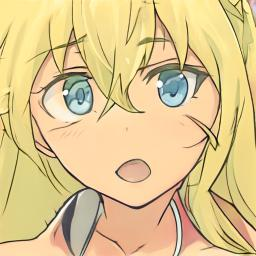

In [5]:
#@title { display-mode: "form", run: "auto" }

layer_idx = "all" #@param ['all', '0-1', '2-5', '6-13']
semantic_1 = 2.0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_2 = 0.5 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_3 = 0.5 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_4 = 1.8 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
semantic_5 = 1.6 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

# Fast implementation to factorize the weight by SeFa.
layers, boundaries, _ = factorize_weight(generator, layer_idx)

new_codes = codes.copy()
for sem_idx in range(5):
  boundary = boundaries[sem_idx:sem_idx + 1]
  step = eval(f'semantic_{sem_idx + 1}')
  if gan_type == 'pggan':
    new_codes += boundary * step
  elif gan_type in ['stylegan', 'stylegan2']:
    new_codes[:, layers, :] += boundary * step
new_images = synthesize(generator, gan_type, new_codes)
imshow(new_images, col=num_samples)